In [41]:
from google.cloud import bigquery
from functions import *
# Numpy & Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import warnings

# Set the warning filter to ignore all warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

from scipy.stats import chi2_contingency

In [2]:
# set display options to show all columns
pd.set_option('display.max_columns', None)
# Set the float format to display numbers without scientific notation
pd.options.display.float_format = '{:.2f}'.format
# Set the client for future queries to BigQuery
client = bigquery.Client(project = "continente-lced-feup")
#data_table.enable_dataframe_formatter()
#auth.authenticate_user()

In [3]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=y8WnvzxydLaS5lY7XBq336X6L4G3Ou&access_type=offline&code_challenge=-ZnUFwyDOYjiUIrU4EcAvf3eaGqvHKRAend6o3o97HM&code_challenge_method=S256


Credentials saved to file: [/Users/vp/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "continente-lced-feup" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the r

In [4]:
query = client.query("""
   SELECT *
   FROM 
       tables_staging.df_models
  LIMIT 2000000
   """)

df = query.result().to_dataframe() # Wait for the job to complete.
df

,CUSTOMER_ACCOUNT_NR_MASK,SUBCAT_CD_EXT,MONTH,YEAR,QUARTER,SEMESTER,CUST_NUM_TRANSACTIONS_30_DAYS,CUST_NUM_TRANSACTIONS_90_DAYS,CUST_NUM_TRANSACTIONS_180_DAYS,CUST_NUM_TRANSACTIONS_360_DAYS,CUST_TOTAL_QTY_BOUGHT_30_DAYS,CUST_TOTAL_QTY_BOUGHT_90_DAYS,CUST_TOTAL_QTY_BOUGHT_180_DAYS,CUST_TOTAL_QTY_BOUGHT_360_DAYS,CUST_NUM_UNIQUE_SUBCAT_30_DAYS,CUST_NUM_UNIQUE_SUBCAT_90_DAYS,CUST_NUM_UNIQUE_SUBCAT_180_DAYS,CUST_NUM_UNIQUE_SUBCAT_360_DAYS,CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS,CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_90_DAYS,CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_180_DAYS,CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_360_DAYS,REG_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS,CUST_AVG_BASKET_SIZE_30_DAYS,CUST_AVG_BASKET_SIZE_90_DAYS,CUST_AVG_BASKET_SIZE_180_DAYS,CUST_AVG_BASKET_SIZE_360_DAYS,SUBCAT_NUM_TRANSACTIONS_30_DAYS,SUBCAT_NUM_TRANSACTIONS_90_DAYS,SUBCAT_NUM_TRANSACTIONS_180_DAYS,SUBCAT_NUM_TRANSACTIONS_360_DAYS,SUBCAT_TOTAL_QTY_BOUGHT_30_DAYS,SUBCAT_TOTAL_QTY_BOUGHT_90_DAYS,SUBCAT_TOTAL_QTY_BOUGHT_180_DAYS,SUBCAT_TOTAL_QTY_BOUGHT_360_DAYS,SUBCAT_NUM_UNIQUE_CUST_30_DAYS,SUBCAT_NUM_UNIQUE_CUST_90_DAYS,SUBCAT_NUM_UNIQUE_CUST_180_DAYS,SUBCAT_NUM_UNIQUE_CUST_360_DAYS,CUSTSUBCAT_NUM_TRANSACTIONS_30_DAYS,CUSTSUBCAT_NUM_TRANSACTIONS_90_DAYS,CUSTSUBCAT_NUM_TRANSACTIONS_180_DAYS,CUSTSUBCAT_NUM_TRANSACTIONS_360_DAYS,CUSTSUBCAT_TOTAL_QTY_BOUGHT_30_DAYS,CUSTSUBCAT_TOTAL_QTY_BOUGHT_90_DAYS,CUSTSUBCAT_TOTAL_QTY_BOUGHT_180_DAYS,CUSTSUBCAT_TOTAL_QTY_BOUGHT_360_DAYS,CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS,CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_90_DAYS,CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_180_DAYS,CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_360_DAYS,GENDER,FAMILY_MEMBERS,SEG_LIFESTYLE_CD,SEG_LIFESTAGE_CD,CAT_CD_EXT,TARGET
0,35049284,80403,1,2021,1,1,1,1,1,1,5,5,5,5,3,3,3,3,30,60,180,360,0.00,3.00,3.00,3.00,3.00,55,55,55,55,1793,1793,1793,1793,828,828,828,828,0,0,0,0,0,0,0,0,0,0,0,0,F,"(3, 8)",3,5,804,0
1,83408221,140301,1,2022,1,1,4,12,20,25,123,341,569,719,38,52,64,68,9,7,9,13,6.00,18.25,18.33,18.40,18.68,47,144,267,515,1744,4955,9330,18689,979,1873,2534,3439,0,0,0,0,0,0,0,0,0,0,0,0,M,"(1, 2)",3,4,1403,0
2,66761145,140301,1,2022,1,1,10,26,50,81,139,324,571,843,41,52,62,76,3,3,3,4,2.00,9.10,7.81,7.82,7.31,47,144,267,515,1744,4955,9330,18689,979,1873,2534,3439,0,0,0,0,2,4,7,10,30,60,29,29,F,"(3, 8)",1,5,1403,0
3,58332519,140301,1,2022,1,1,2,7,17,52,11,120,312,876,8,44,71,85,8,14,10,6,6.00,5.00,12.86,14.41,13.31,47,144,267,515,1744,4955,9330,18689,979,1873,2534,3439,0,0,0,0,0,0,0,0,0,0,0,0,M,"(1, 2)",3,4,1403,0
4,83750823,170112,1,2021,1,1,1,1,1,1,21,21,21,21,11,11,11,11,30,60,180,360,30.00,15.00,15.00,15.00,15.00,1,1,1,1,9,9,9,9,7,7,7,7,0,0,0,0,0,0,0,0,0,0,0,0,M,"(1, 2)",1,3,1701,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,18971389,80111,3,2021,1,1,3,5,5,5,14,19,19,19,11,14,14,14,14,16,16,16,26.00,4.67,3.80,3.80,3.80,3,8,8,8,28,136,136,136,14,50,50,50,0,0,0,0,0,0,0,0,0,0,0,0,M,"(1, 2)",2,3,801,0
1999996,79542193,170310,4,2021,2,1,4,13,18,18,64,235,267,267,23,41,43,43,8,7,6,6,4.00,13.50,13.69,11.39,11.39,11,18,22,22,101,301,392,392,68,184,227,227,0,0,0,0,0,0,0,0,0,0,0,0,M,"(1, 2)",1,5,1703,0
1999997,34987019,170310,4,2021,2,1,1,2,2,2,28,65,65,65,17,26,26,26,30,77,77,77,12.00,23.00,25.00,25.00,25.00,11,18,22,22,101,301,392,392,68,184,227,227,0,0,0,0,0,0,0,0,0,0,0,0,F,"(1, 2)",1,3,1703,0
1999998,2381096,170310,4,2021,2,1,7,15,20,20,135,323,387,387,34,51,55,55,4,5,5,5,5.00,11.00,13.40,12.25,12.25,11,18,22,22,101,301,392,392,68,184,227,227,0,0,0,0,2,2,2,2,6,6,6,6,M,"(1, 2)",2,4,1703,0


# Data Preparation

In [5]:
df = df.dropna()
df = df.drop_duplicates()

df['fulldate'] = pd.to_datetime(df['MONTH'].astype(str) + '-' + df['YEAR'].astype(str))
# change from dtype datetime64[ns] to date time month
df['fulldate'] = df['fulldate'].dt.to_period('M')

df_200k = df.groupby('fulldate').sample(frac=0.2, random_state=101)

#drop customer id column because we want to generalize the model, instead of trying to predict for each customer
df_200k = df_200k.drop(columns=['CUSTOMER_ACCOUNT_NR_MASK'])

In [6]:
df_200k.value_counts('fulldate').sort_index()

fulldate
2021-01    14594
2021-02    15962
2021-03    17422
2021-04    17792
2021-05    17433
2021-06    18574
2021-07    19922
2021-08    18184
2021-09     9746
2021-10    11063
2021-11    10424
2021-12    12304
2022-01    20204
2022-02    20277
2022-03    20752
2022-04    21041
2022-05    22014
2022-06    22317
2022-07    21780
2022-08    19374
2022-09    11195
2022-10    12637
2022-11    11830
Freq: M, dtype: int64

In [6]:
numerical_columns = ['CUST_NUM_TRANSACTIONS_30_DAYS', 'CUST_NUM_TRANSACTIONS_90_DAYS',
       'CUST_NUM_TRANSACTIONS_180_DAYS', 'CUST_NUM_TRANSACTIONS_360_DAYS',
       'CUST_NUM_UNIQUE_SUBCAT_30_DAYS', 'CUST_NUM_UNIQUE_SUBCAT_90_DAYS',
       'CUST_NUM_UNIQUE_SUBCAT_180_DAYS', 'CUST_NUM_UNIQUE_SUBCAT_360_DAYS',
       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS',
       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_90_DAYS',
       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_180_DAYS',
       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_360_DAYS',
       'CUST_AVG_BASKET_SIZE_30_DAYS', 'CUST_AVG_BASKET_SIZE_90_DAYS',
       'CUST_AVG_BASKET_SIZE_180_DAYS', 'CUST_AVG_BASKET_SIZE_360_DAYS',
       'SUBCAT_NUM_TRANSACTIONS_30_DAYS', 'SUBCAT_NUM_TRANSACTIONS_90_DAYS',
       'SUBCAT_NUM_TRANSACTIONS_180_DAYS', 'SUBCAT_NUM_TRANSACTIONS_360_DAYS',
       'SUBCAT_NUM_UNIQUE_CUST_30_DAYS', 'SUBCAT_NUM_UNIQUE_CUST_90_DAYS',
       'SUBCAT_NUM_UNIQUE_CUST_180_DAYS', 'SUBCAT_NUM_UNIQUE_CUST_360_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_30_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_90_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_180_DAYS',
       'CUSTSUBCAT_NUM_TRANSACTIONS_360_DAYS',
       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS',
       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_90_DAYS',
       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_180_DAYS',
       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_360_DAYS']

scaler = MinMaxScaler()
df_200k[numerical_columns] = scaler.fit_transform(df_200k[numerical_columns])

Feature selection: Filter methods

In [12]:
def our_heatmap(df_values, threshold=1.1):

    # Define the colors
    colors = ['#84161a', '#fcf2f2']

    # Create a list of relative positions for each color
    positions = [0, 1]

    # Create the custom colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("", list(zip(positions, colors)))

    # keep only the correlations above the threshold
    df_values = df_values[df_values < threshold]

    # Plot the heatmap with the custom colormap
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(df_values, annot=True, cmap=cmap, vmin=0, vmax=1)

In [13]:
# calculate correlation matrix
corr = df_200k[numerical_columns].corr()

<AxesSubplot:>

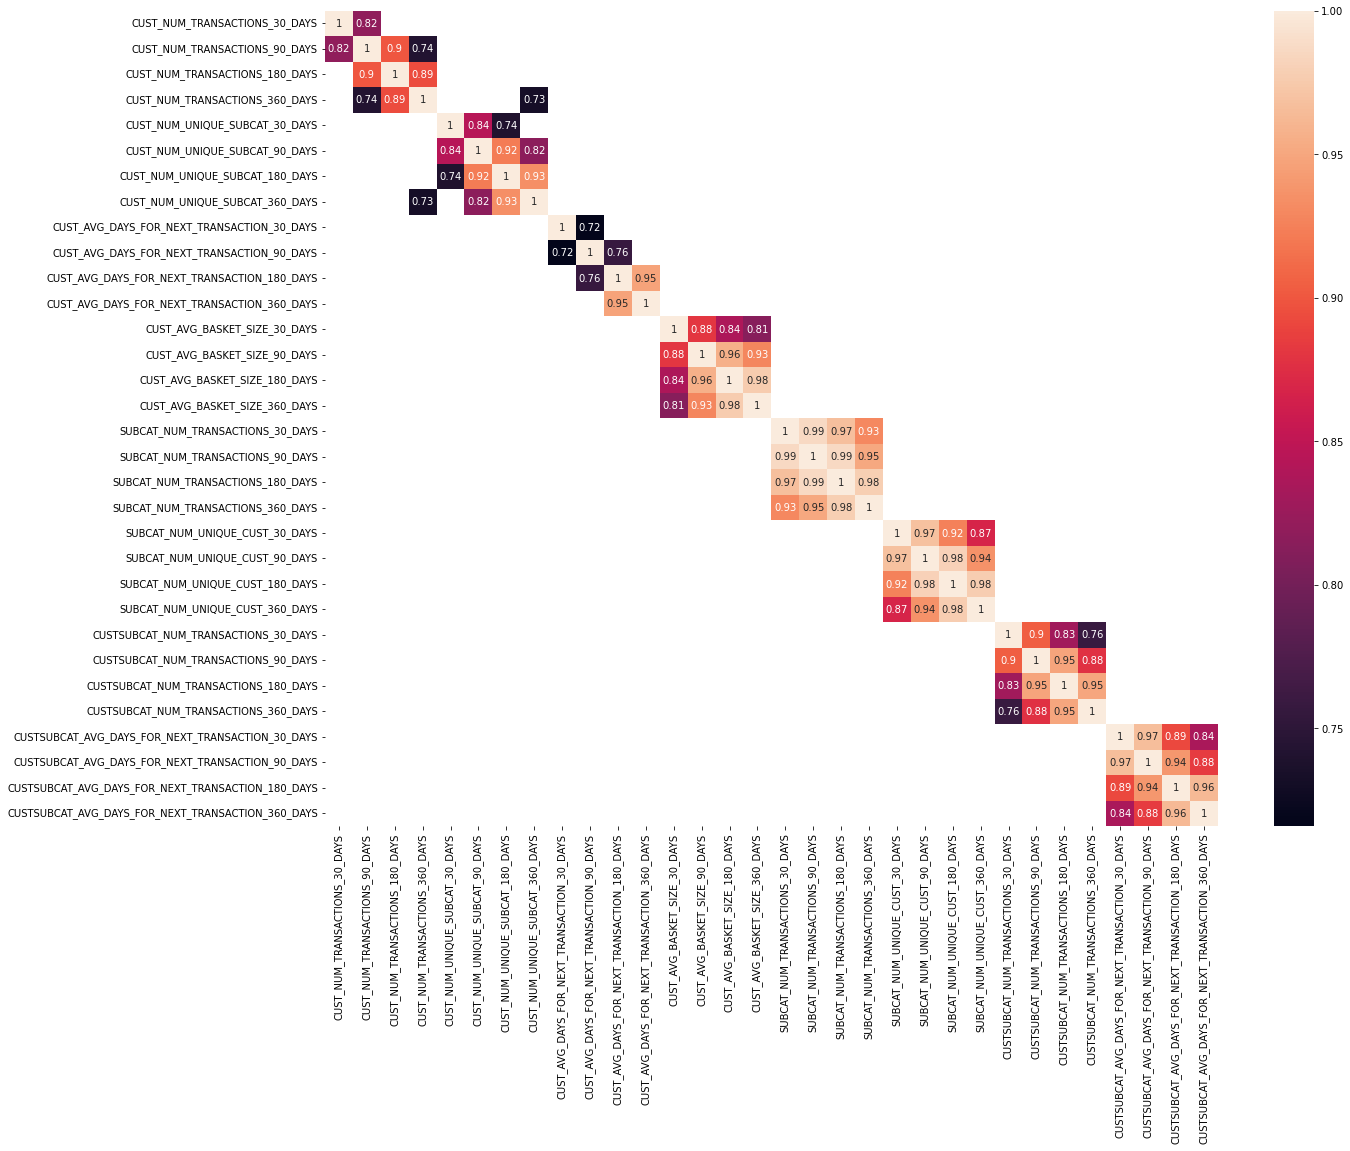

In [14]:
# set the threshold
threshold = 0.7

# keep only the correlations above the threshold
corr = corr[corr > threshold]

# Create the figure and the axes objects
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr,annot = True)

In [17]:
# Bootstrap sampling to identify associations/correlations between categorical variables

categorical_columns = ['SUBCAT_CD_EXT','MONTH','QUARTER','SEMESTER','YEAR','GENDER','SEG_LIFESTYLE_CD','SEG_LIFESTAGE_CD','CAT_CD_EXT', 'FAMILY_MEMBERS']

df_200k = df_200k[categorical_columns]

# Create an empty matrix to store the p-values
pvals = np.zeros((len(df_200k.columns), len(df_200k.columns)))

n_bootstraps = 1000

pvals_ind = [None]*1000

# Loop through all pairs of variables and calculate the p-value
for i, var1 in enumerate(df_200k.columns):
    for j, var2 in enumerate(df_200k.columns):
        if i == j:
            continue
        else:
            for k in range(0, n_bootstraps):
                sample = df_200k.sample(200, replace=True)
                cont_table = pd.crosstab(sample[var1], sample[var2])
                chi2, pval, dof, expected = chi2_contingency(cont_table)
                pvals_ind[k] = pval
        
            pvals[i, j] = np.mean(pvals_ind)

# Convert the matrix to a data frame and print the results
pvals_df = pd.DataFrame(pvals, columns=df_200k.columns, index=df_200k.columns)

pvals_df

,SUBCAT_CD_EXT,MONTH,QUARTER,SEMESTER,YEAR,GENDER,SEG_LIFESTYLE_CD,SEG_LIFESTAGE_CD,CAT_CD_EXT,FAMILY_MEMBERS
SUBCAT_CD_EXT,0.00,0.43,0.45,0.45,0.46,0.48,0.51,0.50,0.00,0.47
MONTH,0.42,0.00,0.00,0.00,0.16,0.51,0.48,0.52,0.45,0.49
QUARTER,0.44,0.00,0.00,0.00,0.34,0.49,0.49,0.50,0.48,0.51
SEMESTER,0.46,0.00,0.00,0.00,0.44,0.59,0.49,0.49,0.49,0.50
YEAR,0.45,0.18,0.34,0.45,0.00,0.57,0.48,0.45,0.47,0.51
GENDER,0.47,0.49,0.50,0.59,0.59,0.00,0.45,0.23,0.48,0.37
SEG_LIFESTYLE_CD,0.50,0.48,0.48,0.50,0.49,0.44,0.00,0.10,0.51,0.36
SEG_LIFESTAGE_CD,0.53,0.51,0.49,0.48,0.46,0.22,0.11,0.00,0.52,0.41
CAT_CD_EXT,0.00,0.46,0.48,0.49,0.47,0.49,0.50,0.54,0.00,0.50
FAMILY_MEMBERS,0.47,0.50,0.50,0.50,0.50,0.35,0.35,0.41,0.50,0.00


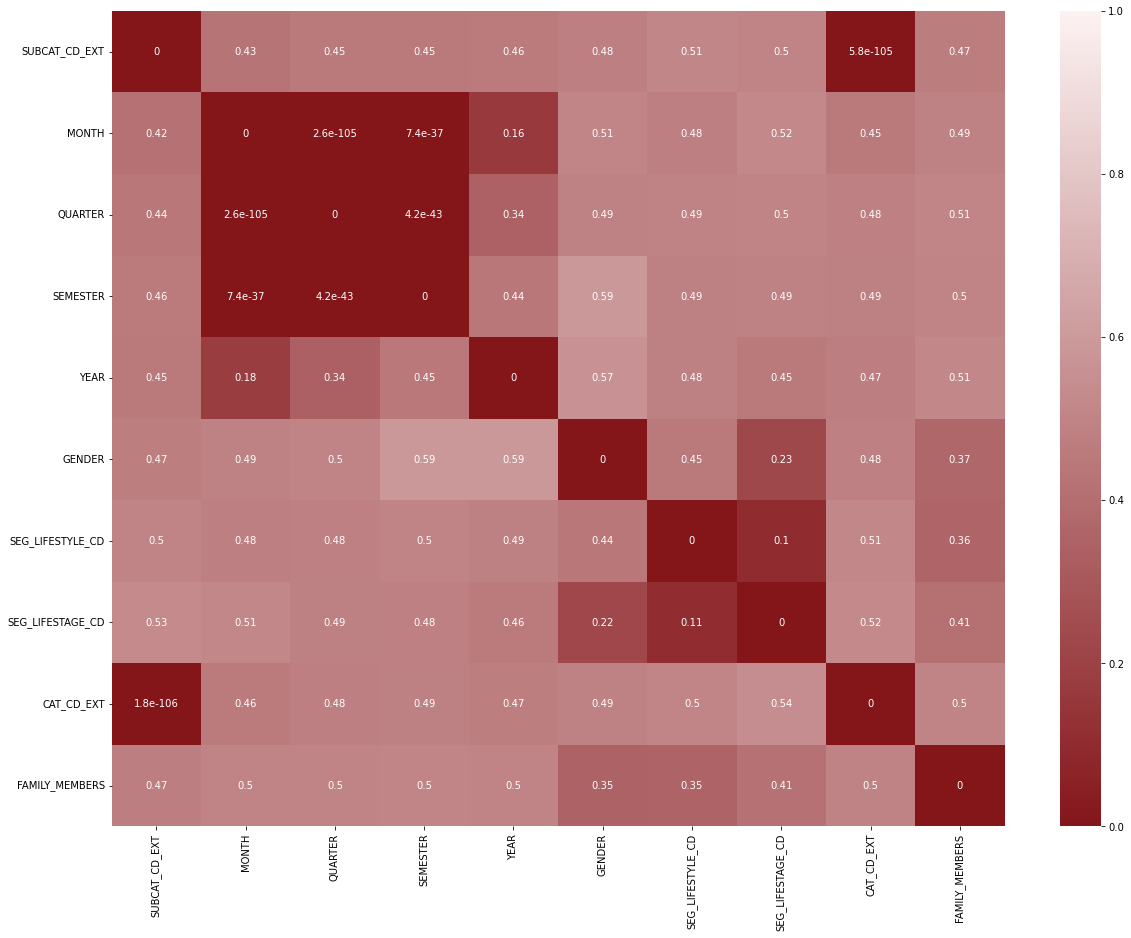

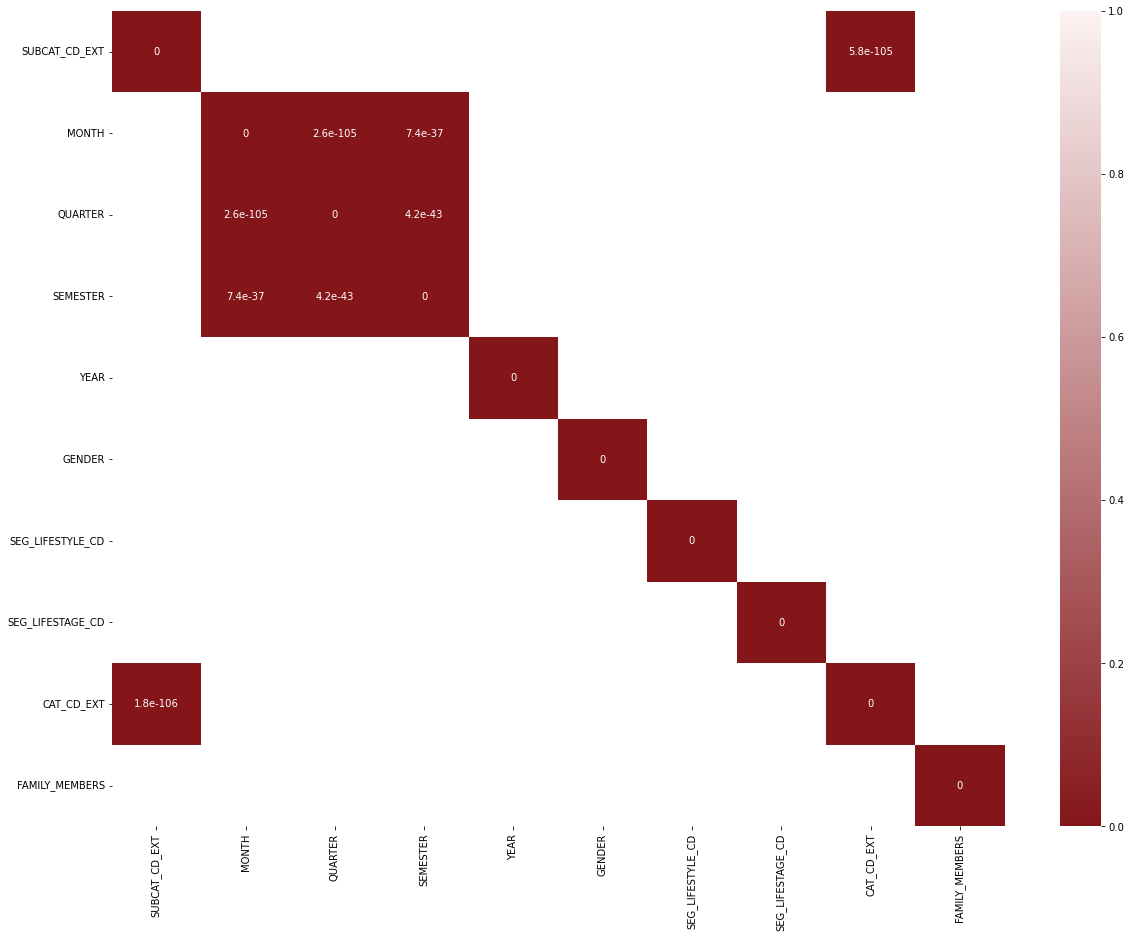

In [18]:
our_heatmap(pvals_df)
our_heatmap(pvals_df, 0.05)

In [7]:
df_200k = df_200k.drop(columns=['QUARTER','SEMESTER','CAT_CD_EXT','SEG_LIFESTYLE_CD', 'YEAR', 'MONTH', 'SUBCAT_CD_EXT'])

In [8]:
# One-hot encoding categorical variables
df_200k = pd.get_dummies(df_200k, columns=['GENDER','SEG_LIFESTAGE_CD', 'FAMILY_MEMBERS'])
df_200k

Outlier detection (unsupervised learning)

In [22]:
def plot_3d_clusters(df_clst, z_rot):
    # Compute the first three principal components of the data
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(df_clst)

    # Create a scatter plot of the first three principal components, colored by cluster
    cluster_colors = np.array(['#de1c26', 'yellow', 'orange', 'red', 'purple', 'black', 'gray', 'magenta', '#84161a'])
    sns.set_style("ticks", {"axes.facecolor": "#ffffff"})
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(principal_components[:,0], principal_components[:,1], principal_components[:,2], c=cluster_colors[df_clst['cluster'].values % len(cluster_colors)], alpha=0.8)
    ax.scatter(principal_components[outliers_mask, 0], principal_components[outliers_mask, 1], principal_components[outliers_mask, 2], c='#84161a', marker='X', s=100, alpha=1.0)
    ax.view_init(elev=10, azim=z_rot)
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')

    ax.w_xaxis.set_pane_color('#fcf2f2')  # Change x-axis color
    ax.w_yaxis.set_pane_color('#fcf2f2')  # Change y-axis color
    ax.w_zaxis.set_pane_color('#fcf2f2')  # Change z-axis color

    
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    #ax.grid(False)

    plt.show()


def plot_2d_clusters(df_clst):
    # Compute the first two principal components of the data
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df_clst)

    # Create a scatter plot of the first three principal components, colored by cluster
    cluster_colors = np.array(['#de1c26', 'yellow', 'orange', 'red', 'purple', 'black', 'gray', 'magenta', '#84161a'])
    sns.set_style("ticks", {"axes.facecolor": "#ffffff"})
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    ax.scatter(principal_components[:,0], principal_components[:,1], c=cluster_colors[df_clst['cluster'].values % len(cluster_colors)], alpha=0.8)
    ax.scatter(principal_components[outliers_mask, 0], principal_components[outliers_mask, 1], c='#84161a', marker='X', s=100, alpha=1.0)

    ax.set_facecolor('#fcf2f2')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.show()

In [25]:
# Extract the numerical columns
df_200k_out = df_200k[numerical_columns]

batch_size = 50000

while len(df_200k_out) > batch_size:
    df_50k = df_200k_out.sample(batch_size, replace=False)
    # Perform DBSCAN clustering and obtain cluster labels
    dbscan = DBSCAN(eps=0.6, min_samples=800)
    labels = dbscan.fit_predict(df_50k)

    # Identify the outliers
    outliers_mask = labels == -1
    outliers = df_50k[outliers_mask]
    df_200k_out = df_200k_out.drop(index=df_50k.index)
    df_200k = df_200k.drop(index=outliers.index)

    print("Number of outliers:", len(outliers))

    # Add cluster labels to the original dataframe
    df_50k['cluster'] = labels


# Perform DBSCAN clustering and obtain cluster labels
dbscan = DBSCAN(eps=0.6, min_samples=800)
labels = dbscan.fit_predict(df_200k_out)

# Identify the outliers
outliers_mask = labels == -1
outliers = df_200k_out[outliers_mask]
df_200k = df_200k.drop(index=outliers.index)

print("Number of outliers:", len(outliers))

# Add cluster labels to the original dataframe
df_200k_out['cluster'] = labels

plot_2d_clusters(df_200k_out)

plot_3d_clusters(df_200k_out, 0)
plot_3d_clusters(df_200k_out, 90)
plot_3d_clusters(df_200k_out, 180)
plot_3d_clusters(df_200k_out, 270)

KeyError: "None of [Index(['CUST_NUM_TRANSACTIONS_30_DAYS', 'CUST_NUM_TRANSACTIONS_90_DAYS',\n       'CUST_NUM_TRANSACTIONS_180_DAYS', 'CUST_NUM_TRANSACTIONS_360_DAYS',\n       'CUST_NUM_UNIQUE_SUBCAT_30_DAYS', 'CUST_NUM_UNIQUE_SUBCAT_90_DAYS',\n       'CUST_NUM_UNIQUE_SUBCAT_180_DAYS', 'CUST_NUM_UNIQUE_SUBCAT_360_DAYS',\n       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS',\n       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_90_DAYS',\n       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_180_DAYS',\n       'CUST_AVG_DAYS_FOR_NEXT_TRANSACTION_360_DAYS',\n       'CUST_AVG_BASKET_SIZE_30_DAYS', 'CUST_AVG_BASKET_SIZE_90_DAYS',\n       'CUST_AVG_BASKET_SIZE_180_DAYS', 'CUST_AVG_BASKET_SIZE_360_DAYS',\n       'SUBCAT_NUM_TRANSACTIONS_30_DAYS', 'SUBCAT_NUM_TRANSACTIONS_90_DAYS',\n       'SUBCAT_NUM_TRANSACTIONS_180_DAYS', 'SUBCAT_NUM_TRANSACTIONS_360_DAYS',\n       'SUBCAT_NUM_UNIQUE_CUST_30_DAYS', 'SUBCAT_NUM_UNIQUE_CUST_90_DAYS',\n       'SUBCAT_NUM_UNIQUE_CUST_180_DAYS', 'SUBCAT_NUM_UNIQUE_CUST_360_DAYS',\n       'CUSTSUBCAT_NUM_TRANSACTIONS_30_DAYS',\n       'CUSTSUBCAT_NUM_TRANSACTIONS_90_DAYS',\n       'CUSTSUBCAT_NUM_TRANSACTIONS_180_DAYS',\n       'CUSTSUBCAT_NUM_TRANSACTIONS_360_DAYS',\n       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS',\n       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_90_DAYS',\n       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_180_DAYS',\n       'CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_360_DAYS'],\n      dtype='object')] are in the [columns]"

In [13]:
df_200k = df_200k.drop('TARGET', axis=1)

# Machine Learning

In [50]:
def reg_metrics(pred_model, x_train, x_test, y_train, y_test):
    """ Function takes in training and testing sets, prediction model, 
    and ouputs the below metrics:
    1. R² or Coefficient of Determination.
    2. Adjusted R²
    3. Mean Squared Error(MSE)
    4. Root-Mean-Squared-Error(RMSE).
    5. Mean-Absolute-Error(MAE).
    """
    global r2
    global adj_r2
    global mse
    global rmse
    global mae
    
    # Get predicted values on x_test
    y_pred = pred_model.predict(x_test)

    #1 & 2 Coefficient of Determination (R² & Adjusted R²)
    print("\n\t--- Coefficient of Determination (R² & Adjusted R²) ---")
    r2 = metrics.r2_score(y_pred=y_pred, y_true=y_test)
    adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)

    print(f"R²\t\t: {r2:.2f}")
    print(f"Adjusted R²\t: {adj_r2:.2f}")

    #3 & 4. MSE and RMSE
    print("\n\t--- Mean Squared Error (MSE & RMSE) ---")
   
    mse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=True)
    rmse = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)
    
    print(f"MSE\t: {mse:.2f}")
    print(f"RMSE\t: {rmse:.2f}")

    #5. MAE
    print("\n\t--- Mean Absolute Error (MAE) ---")
    mae = metrics.mean_absolute_error(y_pred=y_pred, y_true=y_test)
    print(f"RMSE\t: {mae:.2f}")
    
    # Return Accuracy
    #train_acc = "{:.2f}".format(pred_model.score(x_train, y_train)*100)
    #test_acc = "{:.2f}".format(pred_model.score(x_test, y_test)*100)
    
    #Convert variables to a rounded format 
    r2_formatted = "{:.2f}%".format(r2 * 100)
    adj_r2_formatted = "{:.2f}%".format(adj_r2 * 100)
    mse_formatted = "{:.2f}".format(mse)
    rmse_formatted = "{:.2f}".format(rmse)
    mae_formatted = "{:.2f}".format(mae)
    
    # Return metrics as a dictionary
    metrics_dict = {
        'R²': r2_formatted,
        'Adjusted R²': adj_r2_formatted,
        'MSE': mse_formatted,
        'RMSE': rmse_formatted,
        'MAE': mae_formatted
    }
    
    return metrics_dict

In [17]:
def random_oversampling(x_train,y_train):
    ros = RandomOverSampler(random_state=101)
    X_train, y_train = ros.fit_resample(x_train, y_train)
    
    return X_train, y_train

def roSMOTE(x_train,y_train):
    os = SMOTE(random_state=101)
    X_train, y_train = os.fit_resample(x_train, y_train)
    
    return X_train, y_train

def random_undersampling(x_train,y_train):
    rus = RandomUnderSampler(random_state=101)
    X_train, y_train = rus.fit_resample(x_train, y_train)
    
    return X_train, y_train

In [71]:
def LR(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
                # ('pca', PCA()),
                ('clf', LinearRegression())])
    
    param_grid = {}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf, n_features_to_select=0.5, direction='forward', scoring='neg_mean_squared_error', cv=None, n_jobs=-1) # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))
    #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_]))
        
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2, verbose=1, n_jobs=-1)
    LR = Pipeline([('gs', gs)]) 
        
    LR.fit(X_train,y_train)
    #print(LR.classes_)

    # global y_proba
    # y_proba = LR.predict_proba(X_test)

    
    metrics_dict= reg_metrics(LR, X_train, X_test, y_train, y_test)
    return metrics_dict

In [67]:
def lasso(X_train, y_train, X_train_tune, y_train_tune, X_test, y_test):
    clf = Pipeline([
                # ('pca', PCA()),
                ('clf', Lasso())])  

    param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'precompute': ['auto', True, False],
    'max_iter': [100, 500, 1000],
    'tol': [0.0001, 0.001, 0.01]}

    # Use SequentialFeatureSelector for forward/backward selection
    sfs_backward = SequentialFeatureSelector(clf, n_features_to_select=0.5, direction='forward', scoring='neg_mean_squared_error', cv=None, n_jobs=-1) # Does 5-Fold CV

    # Fit the feature selector to the training data
    sfs_backward.fit(X_train_tune, y_train_tune)

    # Get the selected features and transform the data
    X_train = sfs_backward.transform(X_train)
    X_test = sfs_backward.transform(X_test)

    print('Number of selected features: {}'.format(sfs_backward.n_features_to_select_))
    #print('Features selected: {}'.format(sfs_backward.feature_names_in_[sfs_backward.support_]))
        
    gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='precision', cv=2, verbose=1, n_jobs=-1)
    LR = Pipeline([('gs', gs)]) 
        
    LR.fit(X_train,y_train)
    #print(LR.classes_)

    # global y_proba
    # y_proba = LR.predict_proba(X_test)

    
    metrics_dict= reg_metrics(LR, X_train, X_test, y_train, y_test)
    return metrics_dict

In [79]:
def cv_12months(df_ML, model, resampling_tecnique, model_name):
    print(f'\t------- {model_name} -------\n')
    
    timestamps = df_ML['fulldate'].sort_values().unique()
    #display(timestamps.size)

    # find the minimum timestamp
    min_timestamp = timestamps[0]

    #store each of the metrics in an array for each one
    rsquared_array = np.array([])
    adjrsquared_array = np.array([])
    mse_array = np.array([])
    rmse_array = np.array([])
    mae_array = np.array([])

    
    #probability_array = np.array([])

    # full_xtest_df = []

    df_total = pd.DataFrame()


    full_test_count = 0
    

    
    # iterate over the timestamps and check if the time difference is less than 12 months
    for ts in timestamps[:-3]:
        if ts + 13 > timestamps.max():
            print('\n----------------------------\n\n')
            print(f'R² Mean of all iterations : {np.mean(rsquared_array)}')
            print(f'Adjusted R² Mean of all iterations : {np.mean(adjrsquared_array)}')
            print(f'MSE Mean of all iterations: {np.mean(mse_array)}')
            print(f'RMSE mean of all iterations: {np.mean(rmse_array)}')
            print(f'MAE mean of all iterations: {np.mean(mae_array)}')
            break
        else:
            print('\n----------------------------')
            print(f'\n\nStart Iteration {ts}\n')
            if (ts - min_timestamp).n < 2: # 11
                print(f'Treino feito com os meses: {ts} até {ts+2}') # 11   
                train = df_ML[df_ML['fulldate'].isin([ts, ts+1, ts+2])]  # ts+3, ts+4, ts+5, ts+6, ts+7, ts+8, ts+9, ts+10, ts+11
                train_tune = train.groupby('fulldate').sample(frac=0.3, random_state=101)
                X_train_cv = train.drop(['CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS','fulldate'], axis=1)
                y_train_cv = train['CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int)
                X_train_tune = train_tune.drop(['CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS','fulldate'], axis=1)
                y_train_tune = train_tune['CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int)                
                
                X_train_cv, y_train_cv = resampling_tecnique(X_train_cv, y_train_cv)
                X_train_tune, y_train_tune = random_undersampling(X_train_tune, y_train_tune)

                print('X_train_cv shape: ', X_train_cv.shape)
                print('X_train_tune shape: ', X_train_tune.shape)
            else:
                print(f'Treino feito com os meses: {ts} até {ts+2}') # 11
                train = df_ML[df_ML['fulldate'].isin([ts, ts+1, ts+2])]  # ts+3, ts+4, ts+5, ts+6, ts+7, ts+8, ts+9, ts+10, ts+11
                train_tune = train.groupby('fulldate').sample(frac=0.3, random_state=101)
                X_train_cv = train.drop(['CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS','fulldate'], axis=1)
                y_train_cv = train['CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int)
                X_train_tune = train_tune.drop(['CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS','fulldate'], axis=1)
                y_train_tune = train_tune['CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int) 

                X_train_cv, y_train_cv = resampling_tecnique(X_train_cv, y_train_cv)
                X_train_tune, y_train_tune = random_undersampling(X_train_tune, y_train_tune)
                
                print('X_train_cv shape: ', X_train_cv.shape)
                print('X_train_tune shape: ', X_train_tune.shape)
            
            test = df_ML[df_ML['fulldate'] == ts+3] # 12
            
            X_test = test.drop(['CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS', 'fulldate'], axis=1)

            X_test_pandas = pd.DataFrame(X_test, columns=X_test.columns)

            df_total = df_total.append(X_test_pandas)
            

            # full_xtest_df = pd.concat(X_test)

            full_test_count += X_test.shape[0]


            y_test = test['CUSTSUBCAT_AVG_DAYS_FOR_NEXT_TRANSACTION_30_DAYS'].astype(int)
            print('X_test shape: ', X_test.shape)
            print(f'Teste feito com o mês: {ts+3}')  # 12

            print(f'\nEnd Iteration {ts}\n')
            #print y_train_cv data type
            
            y_pred = model(X_train_cv, y_train_cv, X_train_tune, y_train_tune, X_test, y_test)
            # #append accuracy variable to the accuracy array
            # accuracy_array = np.append(accuracy_array, accuracy)
            rsquared_array = np.append(rsquared_array, r2)
            # #append precision variable to the precision array
            adjrsquared_array = np.append(adjrsquared_array, adj_r2)
            # precision_array = np.append(precision_array, precision)
            # #append recall variable to the recall array
            mse_array = np.append(mse_array, mse)
            # recall_array = np.append(recall_array, recall)
            # #append f1 variable to the f1 array
            rmse_array = np.append(rmse_array, mse)
            # f1_array = np.append(f1_array, f1)
            mae_array = np.append(mae_array, mae)
            #probability_array = np.append(probability_array, y_proba)

    print(f'\n\nNumber of test samples: {full_test_count}')
    return X_train_cv, y_train_cv,X_test, y_test, df_total, y_pred

In [80]:
X_train_cv, y_train_cv,X_test, y_test, df_total, y_pred = cv_12months(df_200k, LR, random_undersampling, 'Linear Regression') 

	------- Linear Regression -------


----------------------------


Start Iteration 2021-01

Treino feito com os meses: 2021-01 até 2021-03
X_train_cv shape:  (1388, 55)
X_train_tune shape:  (404, 55)
X_test shape:  (17792, 55)
Teste feito com o mês: 2021-04

End Iteration 2021-01

Number of selected features: 27
Fitting 2 folds for each of 1 candidates, totalling 2 fits

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.42
Adjusted R²	: 0.41

	--- Mean Squared Error (MSE & RMSE) ---
MSE	: 0.01
RMSE	: 0.09

	--- Mean Absolute Error (MAE) ---
RMSE	: 0.03

----------------------------


Start Iteration 2021-02

Treino feito com os meses: 2021-02 até 2021-04
X_train_cv shape:  (1500, 55)
X_train_tune shape:  (504, 55)
X_test shape:  (17433, 55)
Teste feito com o mês: 2021-05

End Iteration 2021-02

Number of selected features: 27
Fitting 2 folds for each of 1 candidates, totalling 2 fits

	--- Coefficient of Determination (R² & Adjusted R²) ---
R²		: 0.56
Adjusted R²	: 0.55

In [68]:
X_train_cv, y_train_cv,X_test, y_test, df_total, y_pred = cv_12months(df_200k, lasso, random_undersampling, 'Lasso Regression') 

	------- Lasso Regression -------

Start Iteration 2021-01

Treino feito com os meses: 2021-01 até 2021-03
X_train_cv shape:  (1388, 55)
X_train_tune shape:  (404, 55)
X_test shape:  (17792, 55)
Teste feito com o mês: 2021-04

End Iteration 2021-01



TypeError: Lasso() missing 6 required positional arguments: 'X_train', 'y_train', 'X_train_tune', 'y_train_tune', 'X_test', and 'y_test'